In [1]:
import os
import glob
import numpy as np
import pandas as pd

import rasterio
from rasterio.plot import show

import matplotlib.pyplot as plt
import cv2

# reimport 
import utils 
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/utils.py'>

# Vegetation lines

In [5]:
import geopandas as gpd

# Load the shapefile
shapefile_path = "../data/QGIS/Vegetation Lines Howth/vegetation_lines_howth.shp"  # Update with actual path
gdf = gpd.read_file(shapefile_path)
# order by 'id' column
gdf.sort_values(by=["ID","line"], inplace=True)

#Remove ID == 'STOP'
gdf = gdf[gdf['ID'] != 'STOP']

# Remove ID = '20160605T114352' as line is short due to clouds
gdf = gdf[gdf['ID'] != '20160605T114352']

gdf['year'] = gdf['ID'].astype(str).str[:4].astype(int)

# Year >= 2016
gdf = gdf[gdf['year'] >= 2016]

# Display the first few rows
gdf.head()

,ID,line,geometry,year
34,20160513T113322,1.0,"LINESTRING (688613.335 5915252.555, 688607.852...",2016
35,20160513T113322,2.0,"LINESTRING (691345.494 5920826.527, 691349.606...",2016
32,20160516T114402,1.0,"LINESTRING (688624.351 5915267.948, 688621.102...",2016
33,20160516T114402,2.0,"LINESTRING (691339.098 5920802.312, 691328.133...",2016
30,20160602T113322,1.0,"LINESTRING (688617.432 5915257.908, 688611.964...",2016


In [7]:
# Line == 1
gdf_line1 = gdf[gdf['line'] == 1]

# calculate length of each line
gdf_line1['length'] = gdf_line1.geometry.length

gdf_line1

/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/SICS/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,ID,line,geometry,year,length
34,20160513T113322,1.0,"LINESTRING (688613.335 5915252.555, 688607.852...",2016,5290.166734
32,20160516T114402,1.0,"LINESTRING (688624.351 5915267.948, 688621.102...",2016,5162.961172
30,20160602T113322,1.0,"LINESTRING (688617.432 5915257.908, 688611.964...",2016,5286.301478
26,20160824T114352,1.0,"LINESTRING (688617.839 5915258.179, 688614.248...",2016,5238.590932
24,20160920T113312,1.0,"LINESTRING (688622.588 5915265.641, 688619.274...",2016,5217.368379
22,20240421T113321,1.0,"LINESTRING (688615.94 5915256.415, 688607.395 ...",2024,4970.069915
20,20240516T113319,1.0,"LINESTRING (688621.909 5915264.285, 688617.218...",2024,4939.428046
18,20240623T114351,1.0,"LINESTRING (688627.743 5915273.103, 688625.67 ...",2024,4933.015262
16,20240708T114349,1.0,"LINESTRING (688621.909 5915264.692, 688618.246...",2024,4976.086588
14,20240723T114351,1.0,"LINESTRING (688629.778 5915276.088, 688608.772...",2024,4888.831995


In [14]:
# Average lines
from shapely.geometry import LineString
import numpy as np
import geopandas as gpd

def interpolate_line_relative(line, num_points=5000):
    # Interpolate points based on relative distance along the line (0 to 1)
    relative_distances = np.linspace(0, 1, num_points)
    return [line.interpolate(rd * line.length) for rd in relative_distances]

def average_lines(gdf_year, num_points=5000):
    all_coords = []
    for line in gdf_year.geometry:
        points = interpolate_line_relative(line, num_points)
        coords = np.array([[pt.x, pt.y] for pt in points])
        all_coords.append(coords)

    # Stack and average
    all_coords = np.stack(all_coords)  # (n_lines, n_points, 2)
    avg_coords = np.mean(all_coords, axis=0)

    return LineString(avg_coords)

# Generate average lines for 2016 and 2024
avg_lines = []
for year in [2016, 2024]:
    gdf_year = gdf_line1[gdf_line1['year'] == year]
    avg_line = average_lines(gdf_year, num_points=10000)
    avg_lines.append({'year': year, 'geometry': avg_line})

avg_gdf = gpd.GeoDataFrame(avg_lines, crs=gdf.crs)

In [15]:
# Save the average lines to a shapefile
output_shapefile_path = "../data/QGIS/Vegetation Lines Howth/average_lines.shp"
avg_gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')
# Display the average lines

# Plot lines on top of the image

In [7]:
filename = 'S2A_MSIL2A_20240623T114351_N0510_R123_T29UPV_20240623T164349'
aoi_path = f"../data/processed/aoi_crop/{filename}_AOI.tif"

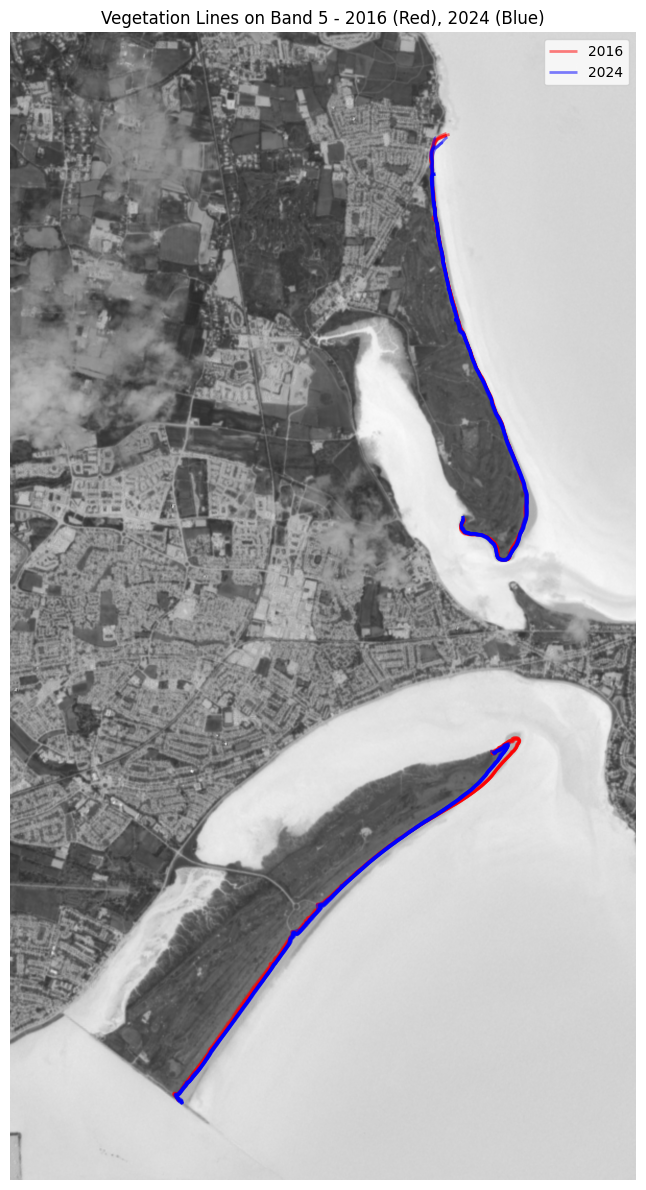

In [9]:
band_index = 5  # <- Change this to the band you want to display (1-based index)


# Filter for years 2016 and 2024
gdf_filtered = gdf[gdf['year'].isin([2016, 2024])]

# --- Open the raster and plot ---
with rasterio.open(aoi_path) as src:
    # Reproject GeoDataFrame to match raster CRS if needed
    if gdf_filtered.crs != src.crs:
        gdf_filtered = gdf_filtered.to_crs(src.crs)

    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Read and show the selected band
    band = src.read(band_index)
    show(band, ax=ax, transform=src.transform, cmap='gray')

    # Plot 2016 lines in red
    gdf_filtered[gdf_filtered['year'] == 2016].plot(ax=ax, 
                                                    edgecolor='red', 
                                                    linewidth=2, 
                                                    label='2016',
                                                    alpha=0.5)

    # Plot 2024 lines in blue
    gdf_filtered[gdf_filtered['year'] == 2024].plot(ax=ax, 
                                                    edgecolor='blue', 
                                                    linewidth=2, 
                                                    label='2024',
                                                    alpha=0.5)

    # Final plot touches
    plt.legend()
    plt.title(f"Vegetation Lines on Band {band_index} - 2016 (Red), 2024 (Blue)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()